In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.linear_model import LinearRegression

In [21]:
# Get the data
qqq = yf.download(tickers="QQQ", period="24h", interval="1m")
btc = yf.download(tickers="BTC-USD", period="24h", interval="1m")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [22]:
df = qqq.merge(btc,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_qqq","_btc"])
print(df.tail())

                             Open_qqq    High_qqq     Low_qqq   Close_qqq  \
Datetime                                                                    
2022-04-28 15:54:00-04:00  327.619995  327.970001  327.440002  327.619995   
2022-04-28 15:55:00-04:00  327.619995  327.619995  326.980011  327.049988   
2022-04-28 15:57:00-04:00  327.274994  327.450012  327.190002  327.385010   
2022-04-28 15:58:00-04:00  327.375000  327.549988  327.290009  327.420105   
2022-04-28 15:59:00-04:00  327.410004  328.079987  327.309998  327.929993   

                           Adj Close_qqq  Volume_qqq      Open_btc  \
Datetime                                                             
2022-04-28 15:54:00-04:00     327.619995      471538  39961.671875   
2022-04-28 15:55:00-04:00     327.049988      461269  39955.113281   
2022-04-28 15:57:00-04:00     327.385010      368311  39952.386719   
2022-04-28 15:58:00-04:00     327.420105      658858  39948.507812   
2022-04-28 15:59:00-04:00     327.929993

In [23]:
y1 = df['Close_qqq']
y2 = df['Close_btc']
y1 = (y1 - np.mean(y1)) / np.std(y1)
y2 = (y2 - np.mean(y2)) / np.std(y2)

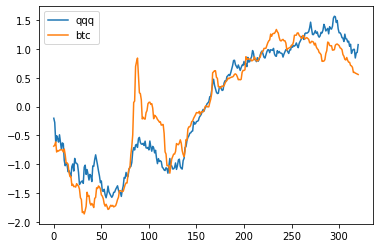

In [24]:
plt.plot(range(len(y1)),y1, label="qqq")
plt.plot(range(len(y2)),y2, label="btc")
plt.legend()

In [25]:
def max_offset(df1, df2):
#     print(len(df1), len(df2))
    corrs = signal.correlate(df1, df2, mode='full')
    return np.argmax(corrs) - len(df1) + 1, corrs[np.argmax(corrs)]
print(max_offset(y1,y2))

(0, 300.3490086978951)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


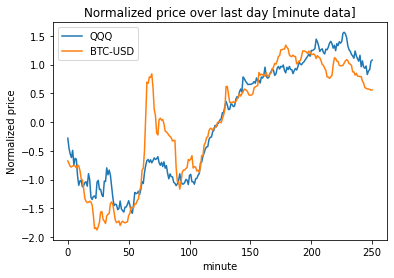

(0, 231.30716844502484)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


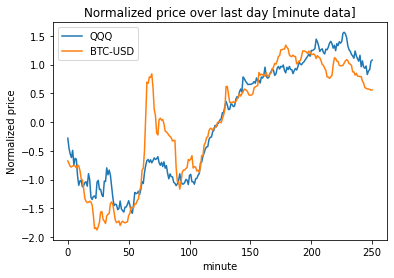

0     -0.280503
1     -0.454980
2     -0.556548
3     -0.616440
4     -0.491411
         ...   
246    0.826283
247    0.886183
248    0.913530
249    1.055455
250    1.076293
Name: Close_a, Length: 251, dtype: float64 0     -0.675162
1     -0.722570
2     -0.771196
3     -0.780845
4     -0.762849
         ...   
246    0.576290
247    0.573684
248    0.569700
249    0.552789
250    0.560607
Name: Close_b, Length: 251, dtype: float64
(0, 1575.1947089148198, [(0.016511420122907385, 0), (0.003272429970654616, 15), (0.021616779077192352, 30), (0.05496627170834905, 45), (0.00531324772241191, 60), (0.02272115903327877, 75), (7.672018985117185e-05, 90), (0.0005919396006699718, 105), (0.006824659151045354, 120), (0.0012636084294408295, 135), (0.017050181967555395, 150), (0.0029606638454186106, 165), (0.019454188951141222, 180), (0.017664244171132305, 195), (0.004421400878676679, 210)])


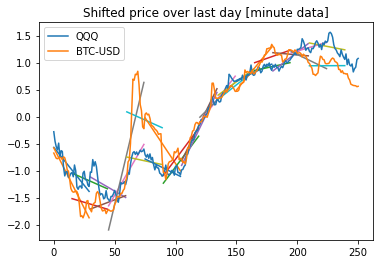

In [47]:
def ticker_offset(str1, str2, silent=False):
    a = yf.download(tickers=str1, period="24h", interval="1m")
    b = yf.download(tickers=str2, period="24h", interval="1m")
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    return max_offset(y1,y2)

def ticker_offset_slope_loss(str1, str2, silent=False):
    a = yf.download(tickers=str1, period="24h", interval="1m")
    b = yf.download(tickers=str2, period="24h", interval="1m")
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    if not silent:
        plt.plot(range(len(y1)),y1, label=str1)
        plt.plot(range(len(y2)),y2, label=str2)
        plt.legend()
        plt.title("Normalized price over last day [minute data]")
        plt.ylabel("Normalized price")
        plt.xlabel("minute")
        plt.show()
    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a']
    y2 = shift_df['Close_b']
    y1_original = y1[:]
    y2_original = y2[:]
    
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    print(y1, y2)
    f, ax = plt.subplots()
    def slope_loss(k, s):
        diffs = []
        for i in range(0, len(y1)-k, s):
            xs = np.array(range(i, i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])
            ax.plot([xs[0], xs[-1]], [starty, endy])
            #print("Slope 2", reg2)
#             print(type(xs[0]))
            diffs.append((abs(reg1-reg2), list(xs[0])[0]))
#             if i*s < len(y1)-k: 
#                 print(shift_df.iloc[i * s, :])
#         print(np.where(shift_df[shift_df[]))

        #print(diffs)
        return np.sum(diffs), diffs
        
    total_slope_loss, diffs = slope_loss(30, 15)
    if not silent:
        ax.plot(range(len(y1)),y1, label=str1)
        ax.plot(range(len(y2)),y2, label=str2)
        ax.legend()
        ax.set_title("Shifted price over last day [minute data]")
        #ax.ylabel("Normalized price")
        #ax.xlabel("minute")
        #ax.show()
    return offset, total_slope_loss, diffs, y1_original, y2_original
print(ticker_offset("QQQ","BTC-USD"))
print(ticker_offset_slope_loss("QQQ","BTC-USD")[:3])



In [ ]:
## Early ticker offset does not plot and only uses the 
# first half of the data to find the shift for correlation

def early_ticker_offset(str1, str2):
    a = yf.download(tickers=str1, period="24h", interval="1m", progress=False)
    b = yf.download(tickers=str2, period="24h", interval="1m", progress=False)
    df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime", suffixes=["_a","_b"])
    
    ## Use only the first half of the day
    df = df[:len(df)//2]
    y1 = df['Close_a']
    y2 = df['Close_b']
    y1_original = y1[:]
    y2_original = y2[:]
    
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)

    offset = max_offset(y1,y2)[0]
    b["Datetime_shift"] = b.index + pd.Timedelta(minutes=offset)
    shift_df = a.merge(b,how="inner", left_on="Datetime", right_on="Datetime_shift", suffixes=["_a","_b"])
    y1 = shift_df['Close_a'][:len(df)//2]
    y2 = shift_df['Close_b'][:len(df)//2]
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)
    
    def slope_loss(k, s):
        diffs = []
        for i in range(0,len(y1)-k, s):
            xs = np.array(range(i,i+k)).reshape(-1, 1)
            line1 = LinearRegression().fit(xs, y1[i:i+k])
            starty = line1.predict([xs[0]])
            endy = line1.predict([xs[-1]])

            reg1 = line1.coef_[0]
            #print("Slope 1 ", reg1)
            line2 = LinearRegression().fit(xs, y2[i:i+k])
            reg2 = line2.coef_[0]
            starty = line2.predict([xs[0]])
            endy = line2.predict([xs[-1]])

            #print("Slope 2", reg2)
            diffs.append((abs(reg1-reg2), list(xs[0])[0]))
        #print(diffs)
        return np.sum(diffs), diffs
        
    total_slope_loss, diffs = slope_loss(30, 15)
    return offset, total_slope_loss, diffs, y1_original, y2_original


token_diffs = {}
y1y2_original = {}
tokens = ["QQQ", "BTC-USD", "ETH-USD", "USDT-USD", "BNB-USD", "USDC-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "ALGO-USD", "XRP-USD", "LUNA1-USD", "ADA-USD", "HEX-USD", "AVAX-USD", "DOGE-USD"] # 
offset_matrix = [[None] * len(tokens) for _ in range(len(tokens))] 

for idx1, token1 in enumerate(tokens):
    for idx2, token2 in enumerate(tokens):
        offset, sl, diffs, y1, y2 = early_ticker_offset(token1, token2)
        offset_matrix[idx1][idx2] = offset
        token_diffs[(token1, token2)] = diffs
        y1y2_original[(token1, token2)] = (y1, y2)
        ##filter for time shifts that make sense and that we can use
        # 15min shift is the limit we picked, and <0 so we can use it to trade
        if -15<offset<0:
            print(token1, token2, offset, "slope loss", sl)

QQQ ALGO-USD -1 slope loss 45.06858356917087
QQQ DOGE-USD -1 slope loss 15.09351171036341
BTC-USD BNB-USD -11 slope loss 315.3813418387092
BTC-USD LUNA1-USD -4 slope loss 825.1752483148396
BTC-USD LUNA1-USD -4 slope loss 825.1752483148396
ETH-USD BNB-USD -9 slope loss 990.1043365332889
ETH-USD LUNA1-USD -4 slope loss 315.25389372143013
ETH-USD LUNA1-USD -4 slope loss 315.25389372143013
USDT-USD QQQ -10 slope loss 15.114528732514232
BNB-USD LUNA1-USD -4 slope loss 225.18530325598343
BNB-USD LUNA1-USD -4 slope loss 225.18530325598343


In [ ]:
trading_trigger_threshold = 0.01
for i in range(len(diffs)-1):
    if diffs[i+1] - diffs[i] > 
    
        